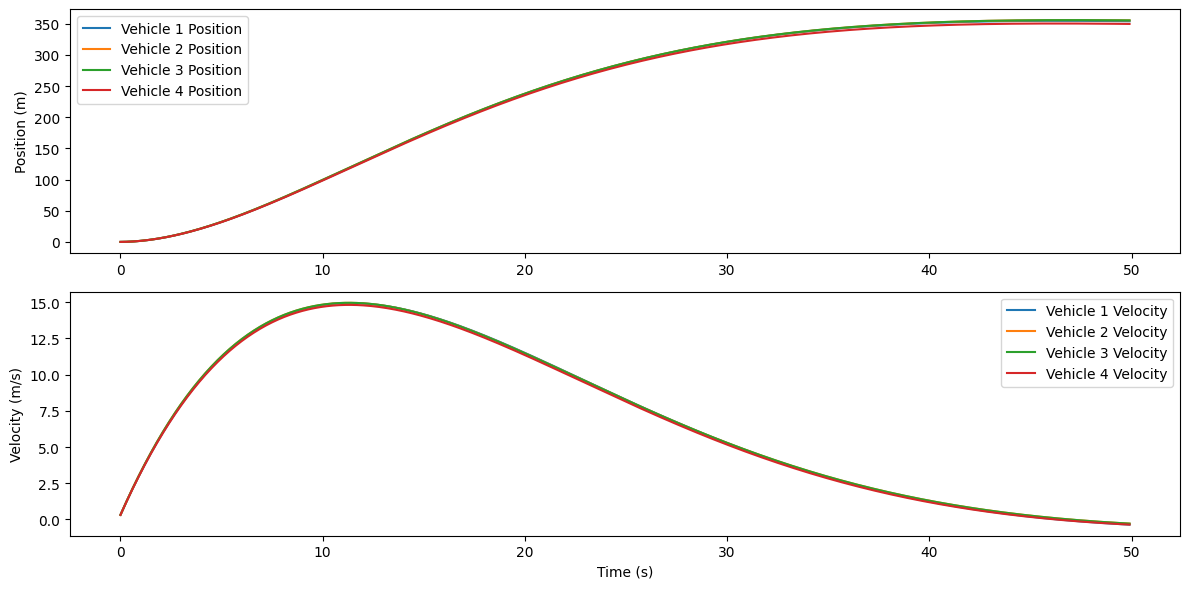

In [53]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy
from scipy.signal import cont2discrete
from scipy.linalg import expm, solve_discrete_are

# Define parameters for the platoon dynamics
k_e, k_s, k_i, k_d = 0.5, 1.0, 0.1, 0.5  # Example gain parameters
T_s = 1.0  # Sampling time
tau = 2.0  # Time headway
m = 1000  # Mass of the vehicle in kg
v_ref = 20  # Reference speed in m/s
alpha = 0  # Road grade (in radians) set to be 0 considering flat road
N = 4  # Number of vehicles in the platoon
n_vehicles = 4
spacing_desired = tau * v_ref  # Desired spacing between vehicles (meters)
v_desired = 20  # Desired velocity (m/s)
a_max = 2  # Max acceleration (m/s^2)
dt = 0.1  # Time step (seconds)
t_end = 50  # Simulation end time (seconds)
time = np.arange(0, t_end, dt)

# Initial conditions for all vehicles (placeholder values)
x_initial = np.zeros(2 * N)  # For each vehicle: position and velocity
d_initial = 50 * np.ones(N-1)  # Initial distances between vehicles
z_initial = np.concatenate((x_initial, d_initial))  # Initial state vector

# Differential equations for the platoon dynamics
def platoon_dynamics(z, t, N, k_e, k_s, k_i, k_d, T_s, tau, m, v_ref):
    # z is the state vector containing positions and velocities of all vehicles and distances
    # t is the time variable
    # Unpack the state vector into positions, velocities, and distances
    positions = z[:N]
    velocities = z[N:2*N]
    distances = z[2*N:]

    # Initialize derivatives
    dzdt = np.zeros_like(z)

    # Update the positions and velocities of each vehicle
    for i in range(N):
        if i == 0:  # The leading vehicle
            dzdt[i] = velocities[i]  # Position derivative is the velocity
            # The leading vehicle's acceleration depends only on its desired speed
            dzdt[N + i] = k_e * (v_ref - velocities[i]) / m
        else:  # Following vehicles
            dzdt[i] = velocities[i]  # Position derivative is the velocity
            # Following vehicle's acceleration depends on the leader's behavior
            dzdt[N + i] = k_e * (v_ref - velocities[i]) + k_s * (velocities[i-1] - velocities[i]) \
                          + k_d * (distances[i-1] - tau * velocities[i]) / m
            dzdt[2*N + i - 1] = velocities[i-1] - velocities[i]  # Distance derivative

    return dzdt

# Time points (simulating for 50 seconds with 0.1s intervals)
t = np.linspace(0, 50, 501)

# Solve the ODE
solution = odeint(platoon_dynamics, z_initial, t, args=(N, k_e, k_s, k_i, k_d, T_s, tau, m, v_ref))

n_states = 2 * N 
n_inputs = N

# Initialize the A and B matrices
A = np.zeros((n_states, n_states))
B = np.zeros((n_states, n_inputs))

# Recreate the continuous A and B matrices using the parameters
A = np.zeros((n_states, n_states))
for i in range(N):
    A[2*i, 2*i + 1] = 1  # This represents x_dot = v
    if i < N - 1:
        A[2*i + 1, 2*i + 1] = -k_s / m  # This represents the velocity's self influence
        A[2*i + 1, 2*i + 3] = k_s / m  # Influence of the following vehicle's velocity
        A[2*i + 1, 2*(i+1)] = k_d / m  # Influence of the distance to the following vehicle
A[1, 1] = -k_e / m  # The first vehicle's velocity influence

B = np.zeros((n_states, n_inputs))
for i in range(N):
    B[2*i + 1, i] = 1 / m  # This represents the direct influence of the control input

# Define weight matrices for the LQR cost function
Q = np.eye(n_states)  # State weight matrix
R = 0.01 * np.eye(n_inputs)  # Control input weight matrix

# Use cont2discrete function to discretize the system
system_discrete = cont2discrete((A, B, np.eye(n_states), np.zeros((n_states, n_inputs))), dt=T_s)
Ad_discrete, Bd_discrete, Cd_discrete, Dd_discrete, dt_discrete = system_discrete

# Now we can compute the discrete-time LQR controller gain matrix K using the discretized system matrices
P = solve_discrete_are(Ad_discrete, Bd_discrete, Q, R)
K = np.linalg.inv(R + Bd_discrete.T.dot(P).dot(Bd_discrete)).dot(Bd_discrete.T).dot(P).dot(Ad_discrete)



# Simulation
x = np.copy(x_initial)  # Initialize state
x_history = np.zeros((len(time), len(x_initial)))  # History of states for plotting

for i, t in enumerate(time):
    # Control input
    u = -np.dot(K, x - np.tile(np.array([spacing_desired, v_desired]), n_vehicles))
    # State update
    x = x + np.dot(A, x) * dt + np.dot(B, u) * dt
    x_history[i] = x

# Plot results
plt.figure(figsize=(12, 6))

# Positions of vehicles over time
for i in range(n_vehicles):
    plt.subplot(2, 1, 1)
    plt.plot(time, x_history[:, i*2], label=f'Vehicle {i+1} Position')

# Velocities of vehicles over time
for i in range(n_vehicles):
    plt.subplot(2, 1, 2)
    plt.plot(time, x_history[:, i*2+1], label=f'Vehicle {i+1} Velocity')

plt.subplot(2, 1, 1)
plt.ylabel('Position (m)')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()

plt.tight_layout()
plt.show()

In [61]:
import numpy as np
from scipy.optimize import approx_fprime

# Parameters for the platoon dynamics
k_e, k_s, k_i, k_d = 0.5, 1.0, 0.1, 0.5  # Gain parameters
m = 1000  # Mass of the vehicle in kg
tau = 2.0  # Time headway
v_ref = 20  # Reference speed in m/s
N = 4  # Number of vehicles in the platoon

# Equilibrium velocities for all vehicles
x_eq = v_ref * np.ones(N)

# Control input (acceleration) is zero at equilibrium
u_eq = np.zeros(N)

# Redefine the platoon dynamics function if needed
def platoon_dynamics(z, N, k_e, k_s, k_i, k_d,  tau, m, v_ref):
    # The input z is the velocities of the vehicles
    velocities = z

    # Initialize acceleration derivatives
    dzdt = np.zeros_like(velocities)

    # Update the accelerations based on the difference in velocity and the desired headway
    for i in range(N):
        if i == 0:  # The leading vehicle
            dzdt[i] = k_e * (v_ref - velocities[i]) / m
        else:  # Following vehicles
            # Desired distance is the velocity of the leading vehicle times the headway
            desired_distance = velocities[i-1] * tau
            # Current distance is the velocity of the current vehicle times the headway
            current_distance = velocities[i] * tau
            dzdt[i] = (k_e * (v_ref - velocities[i]) + k_s * (velocities[i-1] - velocities[i]) +
                       k_d * (desired_distance - current_distance)) / m

    return dzdt

# Define the combined dynamics function for Jacobian approximation
def combined_dynamics(z_u, N, k_e, k_s, k_i, k_d, tau, m, v_ref):
    z = z_u[:N]  # State vector (vehicle velocities)
    u = z_u[N:]  # Control vector (accelerations)
    dzdt = platoon_dynamics(z, N, k_e, k_s, k_i, k_d, tau, m, v_ref)
    dzdt += u / m  # Add the control inputs to the accelerations of the vehicles
    return dzdt

# Define the function to approximate the Jacobian matrix for the state
def jacobian_state(z_u):
    return approx_fprime(z_u, lambda z: combined_dynamics(z, N, k_e, k_s, k_i, k_d, tau, m, v_ref), epsilon)

# Define the function to approximate the Jacobian matrix for the input
def jacobian_input(x_eq, u_eq):
    J_input = np.zeros((len(x_eq), len(u_eq)))
    for i in range(len(u_eq)):
        u_perturbed = u_eq.copy()
        u_perturbed[i] += epsilon
        J_input[:, i] = (combined_dynamics(np.concatenate((x_eq, u_perturbed)), N, k_e, k_s, k_i, k_d, tau, m, v_ref) -
                         combined_dynamics(np.concatenate((x_eq, u_eq)), N, k_e, k_s, k_i, k_d, tau, m, v_ref)) / epsilon
    return J_input

# Step size for numerical differentiation
epsilon = np.sqrt(np.finfo(float).eps)

# Calculate the Jacobians for the state and input
z_u_eq = np.concatenate((x_eq, u_eq))
A_jacobian = jacobian_state(z_u_eq)
B_jacobian = jacobian_input(x_eq, u_eq)

# Display the calculated Jacobians
print("Jacobian A:", A_jacobian)
print("Jacobian B:", B_jacobian)



Jacobian A: [[-0.0005  0.      0.      0.      0.001   0.      0.      0.    ]
 [ 0.002  -0.0025  0.      0.      0.      0.001   0.      0.    ]
 [ 0.      0.002  -0.0025  0.      0.      0.      0.001   0.    ]
 [ 0.      0.      0.002  -0.0025  0.      0.      0.      0.001 ]]
Jacobian B: [[0.001 0.    0.    0.   ]
 [0.    0.001 0.    0.   ]
 [0.    0.    0.001 0.   ]
 [0.    0.    0.    0.001]]
